In [2]:
import numpy as np
from numpy import zeros, eye, array, diag, exp, ones, tanh, cosh, dstack, log, hstack, vstack, sinh
from numpy.linalg import solve, norm
from numpy.random import choice, default_rng, randint, randn
from scipy.stats import multivariate_normal as MVN
from scipy.special import logsumexp, ndtr
from scipy.stats import uniform as udist
import math
import time
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import rc
from ipywidgets.widgets import IntSlider
from ipywidgets.widgets import interact
from warnings import resetwarnings, catch_warnings, filterwarnings
import seaborn as sns
import pickle

from Manifolds.GKManifoldNew import GKManifold, data_generator, find_point_on_manifold, find_point_on_manifold_from_θ
from markov_snippets import MSAdaptive, SMCAdaptive
from tangential_hug_functions import TangentialHugSampler
from tangential_hug_functions import HugTangentialMultivariate
from RWM import RWM
from utils import ESS_univariate
from utils import send_notification_to_iphone

seed = 1234
m = 20     # number of latent variables
d = m + 4  # dimensionality of x-component

In [4]:
θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
ystar     = data_generator(θ0, m, seed=seed)  # Observed data
q         = MVN(zeros(d), eye(d))             # Proposal distribution for THUG
resetwarnings()
manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False)

In [28]:
def generate_settings(
    d=d, 
    N=2000,
    B=20,
    δ=0.01,
    δmin=1e-3,
    δmax=100.0,
    εmin=1e-16,
    min_pm=1e-4,
    maxiter=500,
    verbose=False,
    εs_fixed=None,
    adaptiveε=True,
    adaptiveδ=False,
    z0_manual=None,
    pm_target=0.23,
    pd_target=0.4,
    dm_target=0.01,
    pm_switch=0.1,
    prior_seed=seed,
    low_memory=True,
    integrator='rwm',
    εprop_switch=0.01,
    ε0_manual=None,
    quantile_value=0.9,
    initialization='manual',
    switch_strategy='pm',
    kernel='uniform',
    prior_scale=7,
    thinning=10,
    burnin=100,
    use_autograd=False,
    stopping_criterion={'εmin', 'pm'},
    resampling_seed=1234,
    mh_kernel_seed=1234,
    resampling_scheme='multinomial',
    prop_hug=0.5,
    projection_method='qr',
    metropolised=False,
    δadaptation_method='ap',
    prop_esjd=0.95,
    adaptiveB=False,
    Bmin=5,
    Bmax=100,
    proxy_ap_metric='dm',
    adaptiveN=False,
    NBbudget=None,
    Badaptation_method=None,
    adaptive_prophug=False,
    min_prop_hug=0.1,
    max_prop_hug=0.9):
    # here d represents m+4
    # Generate the manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=seed)  # Observed data
    q         = MVN(zeros(d), eye(d))             # Proposal distribution for THUG
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type=kernel, use_autograd=use_autograd)
    # grab arguments
    arguments = locals()
    return arguments

δmin   = 1e-3
min_pm = 1e-4
pm_switch = 0.1

# Observed Data

In [5]:
ystar

array([ 2.20517002,  3.06752075,  4.38657593,  3.17309127,  4.77882485,
       19.1077929 ,  2.26343794,  5.06907625,  2.17385853,  3.4596839 ,
        2.64154572,  6.720638  ,  2.49741528,  3.80894688,  2.3511728 ,
        1.86440246,  3.62924583,  9.07515891,  3.81038952,  2.44666584])

In [6]:
# Can be reproduced as follows
rng = default_rng(1234)
z = rng.normal(size=20)
ξ = np.r_[θ0, z]
ξ[0] + ξ[1]*(1 + 0.8*np.tanh(ξ[2]*ξ[4:]/2)) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:]

array([ 2.20517002,  3.06752075,  4.38657593,  3.17309127,  4.77882485,
       19.1077929 ,  2.26343794,  5.06907625,  2.17385853,  3.4596839 ,
        2.64154572,  6.720638  ,  2.49741528,  3.80894688,  2.3511728 ,
        1.86440246,  3.62924583,  9.07515891,  3.81038952,  2.44666584])

# Histogram of Samples

In [30]:
with open("experiment93/second_particles10k.pkl", "rb") as file:
    P1_10k = pickle.load(file)

In [ ]:
B10N5k_HAN_01 = MSAdaptive(generate_settings(d=d, N=5000, B=10,
        δ=0.01, δmin=δmin, min_pm=(1/5000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=P1_10k[:5000], pm_target=0.23, pm_switch=pm_switch, low_memory=False, integrator='hug_and_nhug',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=1000, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95, Badaptation_method=None, prop_hug=0.1,
        adaptive_prophug=False))
B10N5k_HAN_01_PARTICLES = B10N5k_HAN_01.sample()

Integrator: HUG + NHUG.
Prop Hug  :  0.1
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 55.2105774338382034
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9118000000000001
	Particle Diversity: 0.4658000000000000
	Moved Diversity: 0.4247164400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 32.0726235252859908
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9130000000000000
	Particle Diversity: 0.4420000000000000
	Moved Diversity: 0.4035460000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.9200434857358317
	Weights computed and normalized.
	SMC Weights computed and normalized.
	

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8744000000000000
	Particle Diversity: 0.4444000000000000
	Moved Diversity: 0.3885833600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.5876837539936837
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8700000000000000
	Particle Diversity: 0.4518000000000000
	Moved Diversity: 0.3930660000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.2668955278897096
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8682000000000000
	Particle Diversity: 0.4478000000000000
	Moved Diversity: 0.3887799600000000
	Step-size kept fixed at: 0.0100000000000000
I

	Trajectories constructed.
	Epsilon: 2.2003321347306417
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7244000000000000
	Particle Diversity: 0.4466000000000000
	Moved Diversity: 0.3235170400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1313202807001375
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7250000000000000
	Particle Diversity: 0.4522000000000000
	Moved Diversity: 0.3278450000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.0685057071719886
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7236000000000000
	Particle Diversity: 0.4496000000000000
	Moved Diversity: 0.3253305

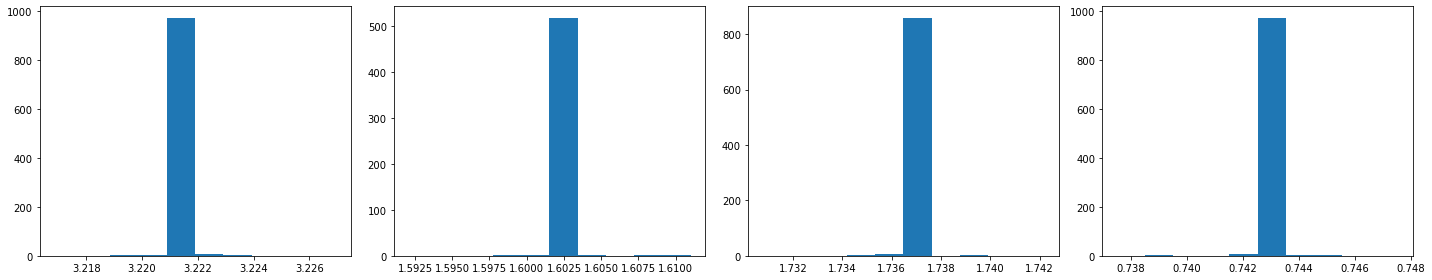

In [26]:
INDEX = 1
USE_VALS = P1_10k #B10N5k_HAN_01.ZN[INDEX, :, :4]
VALS = np.apply_along_axis(manifold.G, 1, USE_VALS)

rc('font',**{'family':'STIXGeneral'})
fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
for i in range(4):
    _ = ax[i].hist(VALS[:, i], density=True)
    ax[i].grid(True, color='lightgray')
    ax[i].set_xlabel(r"$\mathregular{\theta_{" + i + r"}}$", fontsize=20)
    ax[i].tick_params(labelsize=20)
plt.tight_layout()
plt.show()

In [22]:
θ0

array([3. , 1. , 2. , 0.5])

In [ ]:
# B = 2
with open("experiment93/B2N25k_NEW_PARTICLES.pkl", "wb") as file:
    pickle.dump(B2N25k_NEW_PARTICLES, file)

# B = 4 
with open("experiment93/B4N12500_NEW_PARTICLES.pkl", "wb") as file:
    pickle.dump(B4N12500_NEW_PARTICLES, file)

# B = 5
with open("experiment93/B5N10k_PARTICLES.pkl", "wb") as file:
    pickle.dump(B5N10k_PARTICLES, file)
    
# B = 8
with open("experiment93/B8N6250_PARTICLES.pkl", "wb") as file:
    pickle.dump(B8N6250_PARTICLES, file)

# B = 10
with open("experiment93/B10N5000_PARTICLES.pkl", "wb") as file:
    pickle.dump(B10N5000_PARTICLES, file)
    
# B = 20
with open("experiment93/B20N2500_PARTICLES.pkl", "wb") as file:
    pickle.dump(B20N2500_PARTICLES, file)
    
# B = 50 
with open("experiment93/B50N1000_PARTICLES.pkl", "wb") as file:
    pickle.dump(B50N1000_PARTICLES, file)
    
# B = 100
with open("experiment93/KEEP_B_FIXED_PARTICLES.pkl", "wb") as file:
    pickle.dump(KEEP_B_FIXED_PARTICLES, file)
    
# B = 500 
with open("experiment93/B500N100_PARTICLES.pkl", "wb") as file:
    pickle.dump(B500N100_PARTICLES, file)
    
# B = 1000
with open("experiment93/B1000N50_PARTICLES.pkl", "wb") as file:
    pickle.dump(B1000N50_PARTICLES, file)